# Regularization and Gradient Descent Exercises
![UnderOverFit.png](Assets/UnderOverFit.png)


# Learning Objectives

- Explain cost functions, regularization, feature selection, and hyper-parameters
- Summarize complex statistical optimization algorithms like gradient descent and its application to linear regression
- Apply Intel® Extension for Scikit-learn* to leverage underlying compute capabilities of hardware

# scikit-learn* 

Frameworks provide structure that Data Scientists use to build code. Frameworks are more than just libraries, because in addition to callable code, frameworks influence how code is written. 

A main virtue of using an optimized framework is that code runs faster. Code that runs faster is just generally more convenient but when we begin looking at applied data science and AI models, we can see more material benefits. Here you will see how optimization, particularly hyperparameter optimization can benefit more than just speed. 

These exercises will demonstrate how to apply **the Intel® Extension for Scikit-learn*,** a seamless way to speed up your Scikit-learn application. The acceleration is achieved through the use of the Intel® oneAPI Data Analytics Library (oneDAL). Patching is the term used to extend scikit-learn with Intel optimizations and makes it a well-suited machine learning framework for dealing with real-life problems. 

To get optimized versions of many Scikit-learn algorithms using a patch() approach consisting of adding these lines of code prior to importing sklearn: 

- **from sklearnex import patch_sklearn**
- **patch_sklearn()**

## This exercise relies on installation of  Intel® Extension for Scikit-learn*

If you have not already done so, follow the instructions from Week 1 for instructions


## Introduction

We will begin with a short tutorial on regression, polynomial features, and regularization based on a very simple, sparse data set that contains a column of `x` data and associated `y` noisy data. The data file is called `X_Y_Sinusoid_Data.csv`. 

In [1]:
from __future__ import print_function
import os
data_path = ['../data']

from sklearnex import patch_sklearn
patch_sklearn()

from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import SGDRegressor
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge, Lasso
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV
from sklearn.linear_model import ElasticNetCV
from sklearn.linear_model import SGDRegressor
from sklearn.preprocessing import MinMaxScaler

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


## Question 1

* Import the data. 

* Also generate approximately 100 equally spaced x data points over the range of 0 to 1. Using these points, calculate the y-data which represents the "ground truth" (the real function) from the equation: $y = sin(2\pi x)$

* Plot the sparse data (`x` vs `y`) and the calculated ("real") data.


In [2]:
import pandas as pd
import numpy as np

df = pd.read_csv('resources/X_Y_Sinusoid_Data.csv')

X_real = np.linspace(0, 1.0, 100)
Y_real = np.sin(2 * np.pi * X_real)

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

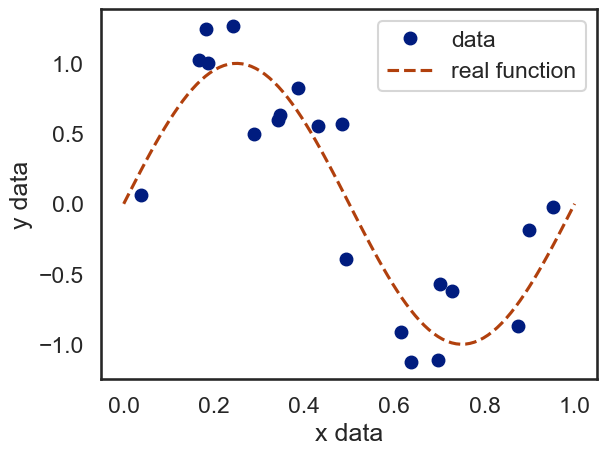

In [4]:
sns.set_style('white')
sns.set_context('talk')
sns.set_palette('dark')

# Plot of the noisy (sparse)
ax = df.set_index('x')['y'].plot(ls='', marker='o', label='data')
ax.plot(X_real, Y_real, ls='--', marker='', label='real function')

ax.legend()
ax.set(xlabel='x data', ylabel='y data');

## Question 2


* Using the `PolynomialFeatures` class from Scikit-learn's preprocessing library, create 20th order polynomial features.
* Fit this data using linear regression. 
* Plot the resulting predicted value compared to the calculated data.

Note that `PolynomialFeatures` requires either a dataframe (with one column, not a Series) or a 2D array of dimension (`X`, 1), where `X` is the length.

In [5]:
degree = 20
pf = PolynomialFeatures(degree)
lr = LinearRegression()

## Question 3

* Perform the regression on using the data with polynomial features using ridge regression ($\alpha$=0.001) and lasso regression ($\alpha$=0.0001). 
* Plot the results, as was done in Question 1. 
* Also plot the magnitude of the coefficients obtained from these regressions, and compare them to those obtained from linear regression in the previous question. The linear regression coefficients will likely need a separate plot (or their own y-axis) due to their large magnitude. 

What does the comparatively large magnitude of the data tell you about the role of regularization?

In [6]:
# Mute the sklearn warning about regularization
import warnings
warnings.filterwarnings('ignore', module='sklearn')

In [7]:
# let's look at the absolute value of coefficients for each model

coefficients = pd.DataFrame()
#update coefficients with all models

#describe coefficients
# Huge difference in scale between non-regularized vs regularized regression

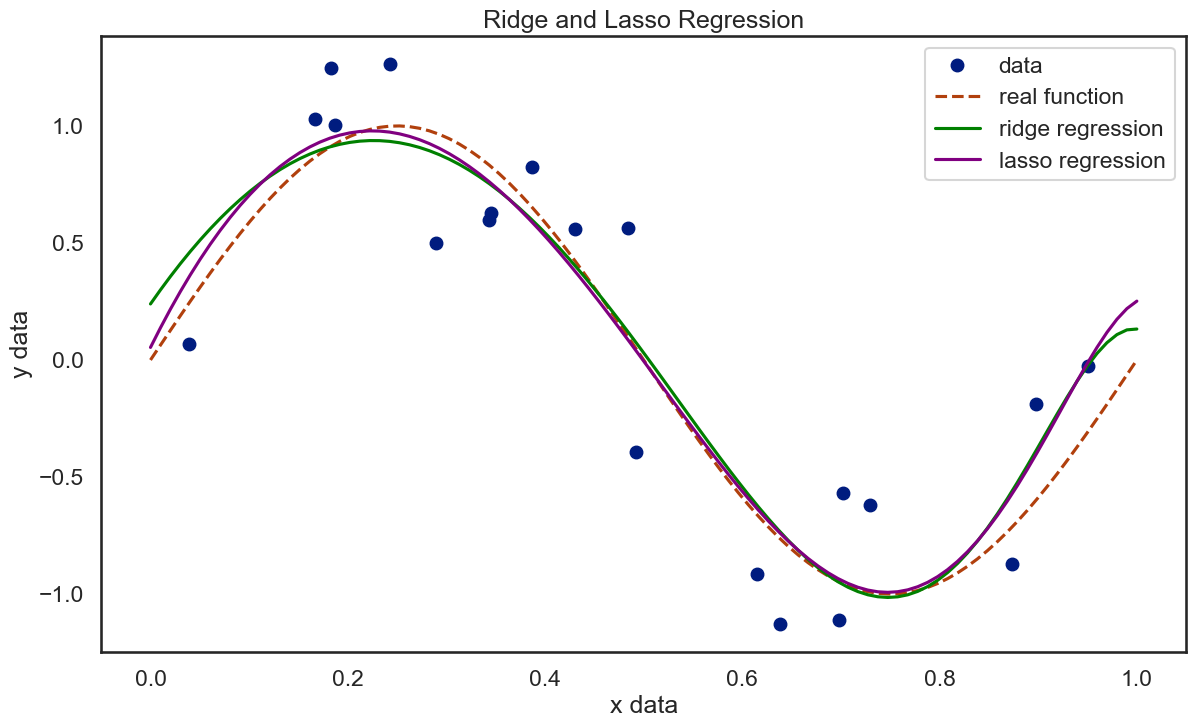

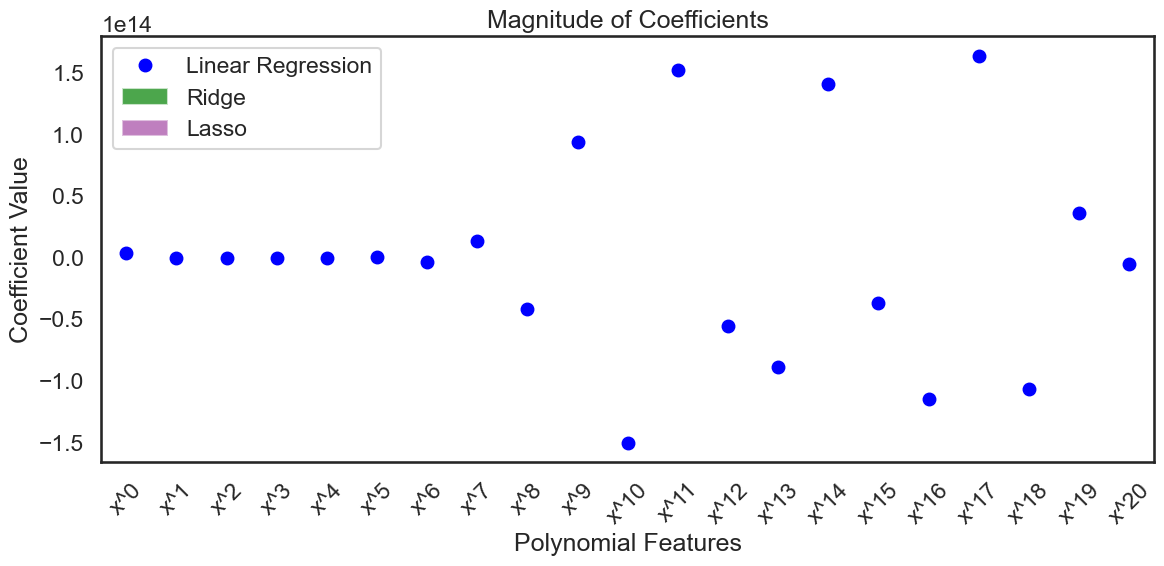

In [8]:
from sklearn.pipeline import make_pipeline

# Ridge Regression
ridge_alpha = 0.001
ridge = Ridge(alpha=ridge_alpha)
ridge_pipe = make_pipeline(pf, ridge)
ridge_pipe.fit(df[['x']], df['y'])

# Lasso Regression
lasso_alpha = 0.0001
lasso = Lasso(alpha=lasso_alpha)
lasso_pipe = make_pipeline(pf, lasso)
lasso_pipe.fit(df[['x']], df['y'])

# Plotting
plt.figure(figsize=(14, 8))

# Plot data points and real function
ax = df.set_index('x')['y'].plot(ls='', marker='o', label='data')
ax.plot(X_real, Y_real, ls='--', marker='', label='real function')

# Plot ridge regression results
ax.plot(X_real, ridge_pipe.predict(X_real.reshape(-1, 1)), color='green', label='ridge regression')

# Plot lasso regression results
ax.plot(X_real, lasso_pipe.predict(X_real.reshape(-1, 1)), color='purple', label='lasso regression')

ax.legend()
ax.set(xlabel='x data', ylabel='y data')
ax.set_title('Ridge and Lasso Regression')

# Plotting magnitude of coefficients
plt.figure(figsize=(12, 6))

# Get polynomial feature names
poly_features = pf.fit_transform(df[['x']])
poly_feature_names = [f'x^{i}' for i in range(poly_features.shape[1])]

# Ridge coefficients
ridge_coefs = pd.Series(ridge_pipe.named_steps['ridge'].coef_, index=poly_feature_names)
ridge_coefs.plot.bar(color='green', alpha=0.7, label='Ridge', legend=True)

# Lasso coefficients
lasso_coefs = pd.Series(lasso_pipe.named_steps['lasso'].coef_, index=poly_feature_names)
lasso_coefs.plot.bar(color='purple', alpha=0.5, label='Lasso', legend=True)

# Linear regression coefficients
lr.fit(pf.fit_transform(df[['x']]), df['y'])
lr_coefs = pd.Series(lr.coef_, index=poly_feature_names)
lr_coefs.plot(color='blue', marker='o', linestyle='None', label='Linear Regression', legend=True)

plt.title('Magnitude of Coefficients')
plt.ylabel('Coefficient Value')
plt.xlabel('Polynomial Features')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()

plt.show()

## Question 4

For the remaining questions, we will be working with the [data set](https://www.kaggle.com/c/house-prices-advanced-regression-techniques) from last lesson, which is based on housing prices in Ames, Iowa. There are an extensive number of features--see the exercises from week three for a discussion of these features.

To begin:

* Import the data with Pandas, remove any null values, and one hot encode categoricals. Either Scikit-learn's feature encoders or Pandas `get_dummies` method can be used.
* Split the data into train and test sets. 
* Log transform skewed features. 
* Scaling can be attempted, although it can be interesting to see how well regularization works without scaling features.

In [10]:
data1 = pd.read_csv("resources/Ames_Housing_Sales.csv")
data = data1.dropna()

Create a list of categorial data and one-hot encode. Pandas one-hot encoder (`get_dummies`) works well with data that is defined as a categorical.

In [11]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

def log_transform_skewed(data):
    skewed_feats = data.apply(lambda x: abs(x.skew())).sort_values(ascending=False)
    skewed_feats = skewed_feats[skewed_feats > 0.75]  # Threshold for skewness
    skewed_feats = skewed_feats.index
    data[skewed_feats] = np.log1p(data[skewed_feats])
    return data

# List of categorical columns
categorical_cols = data.select_dtypes(include=['object']).columns.tolist()

# One-hot encode categorical features
column_transformer = ColumnTransformer(
    transformers=[
        ('onehot', OneHotEncoder(drop='first'), categorical_cols)
    ], remainder='passthrough')

Next, split the data in train and test data sets.

In [16]:
data_cleaned = data1.drop(columns=['Alley'])

from sklearn.model_selection import train_test_split

# Separate features (X) and target variable (y)
X = data_cleaned.drop(columns=['SalePrice'])
y = data_cleaned['SalePrice']

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Print the shapes of the train and test sets
print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_test:", y_test.shape)


Shape of X_train: (1103, 78)
Shape of X_test: (276, 78)
Shape of y_train: (1103,)
Shape of y_test: (276,)


There are a number of columns that have skewed features--a log transformation can be applied to them. Note that this includes the `SalePrice`, our predictor. However, let's keep that one as is.

In [17]:
# Create a list of float columns to check for skewness
float_columns = [col for col in data_cleaned.columns if data_cleaned[col].dtype == 'float64']

# Remove 'SalePrice' from the list (since we want to keep it as is)
float_columns.remove('SalePrice')

# Print the list of float columns
print("Float columns to check for skewness:", float_columns)

Float columns to check for skewness: ['1stFlrSF', '2ndFlrSF', '3SsnPorch', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'EnclosedPorch', 'GarageArea', 'GarageYrBlt', 'GrLivArea', 'LotArea', 'LotFrontage', 'LowQualFinSF', 'MasVnrArea', 'MiscVal', 'OpenPorchSF', 'PoolArea', 'ScreenPorch', 'TotalBsmtSF', 'WoodDeckSF']


Transform all the columns where the skew is greater than 0.75, excluding "SalePrice".

In [18]:
# Calculate skewness for each float column
skewness = data_cleaned[float_columns].apply(lambda x: x.skew())

# Filter columns where skewness is greater than 0.75 (excluding 'SalePrice')
skewed_columns = skewness[skewness > 0.75].index.tolist()

# Apply log transformation to skewed columns
for column in skewed_columns:
    data_cleaned[column] = np.log1p(data_cleaned[column])

# Verify the transformation
print("Columns transformed using log transformation:", skewed_columns)

Columns transformed using log transformation: ['1stFlrSF', '2ndFlrSF', '3SsnPorch', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'EnclosedPorch', 'GarageArea', 'GrLivArea', 'LotArea', 'LotFrontage', 'LowQualFinSF', 'MasVnrArea', 'MiscVal', 'OpenPorchSF', 'PoolArea', 'ScreenPorch', 'TotalBsmtSF', 'WoodDeckSF']


In [19]:
# Mute the setting with a copy warning
pd.options.mode.chained_assignment = None  # default='warn'

Separate features from predictor.

In [20]:
# Separate features (X) and predictor variable (y)
X = data_cleaned.drop(columns=['SalePrice'])
y = data_cleaned['SalePrice']

# Verify the shapes of X and y
print("Shape of features (X):", X.shape)
print("Shape of predictor variable (y):", y.shape)

Shape of features (X): (1379, 78)
Shape of predictor variable (y): (1379,)


## Question 5

* Write a function **`rmse`** that takes in truth and prediction values and returns the root-mean-squared error. Use sklearn's `mean_squared_error`.  


In [21]:
from sklearn.metrics import mean_squared_error
import numpy as np

def rmse(y_true, y_pred):
    """
    Calculate the root mean squared error (RMSE).

    Parameters:
    - y_true: array-like, true values
    - y_pred: array-like, predicted values

    Returns:
    - rmse_score: float, root mean squared error
    """
    mse = mean_squared_error(y_true, y_pred)
    rmse_score = np.sqrt(mse)
    return rmse_score

* Fit a basic linear regression model
* print the root-mean-squared error for this model
* plot the predicted vs actual sale price based on the model.  

In [24]:
# One-hot encode categorical variables
X_encoded = pd.get_dummies(X)

# Split the encoded data into train and test sets
X_train_encoded, X_test_encoded, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

# Fit a basic linear regression model
model = LinearRegression()
model.fit(X_train_encoded, y_train)

# Predict on the test set
y_pred = model.predict(X_test_encoded)

# Calculate the root-mean-squared error
rmse_score = rmse(y_test, y_pred)
print("Root Mean Squared Error (Linear Regression):", rmse_score)   

Root Mean Squared Error (Linear Regression): 35103.23026036544


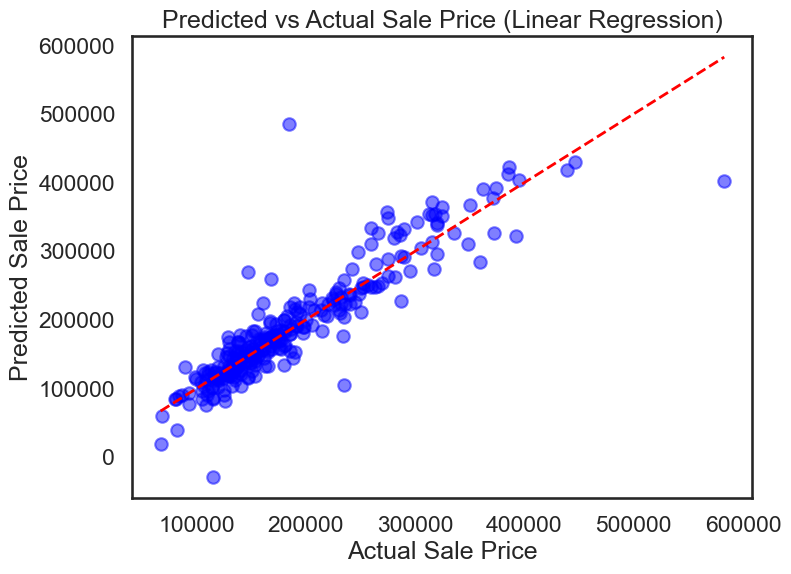

In [25]:
# Plot predicted vs actual sale price
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, color='blue', alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--', color='red', linewidth=2)
plt.title('Predicted vs Actual Sale Price (Linear Regression)')
plt.xlabel('Actual Sale Price')
plt.ylabel('Predicted Sale Price')
plt.show()

## Question 6

Ridge regression uses L2 normalization to reduce the magnitude of the coefficients. This can be helpful in situations where there is high variance. The regularization functions in Scikit-learn each contain versions that have cross-validation built in.

* Fit a regular (non-cross validated) Ridge model to a range of $\alpha$ values and plot the RMSE using the cross validated error function you created above.
* Use $$[0.005, 0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 30, 80]$$ as the range of alphas.
* Then repeat the fitting of the Ridge models using the range of $\alpha$ values from the prior section. Compare the results.

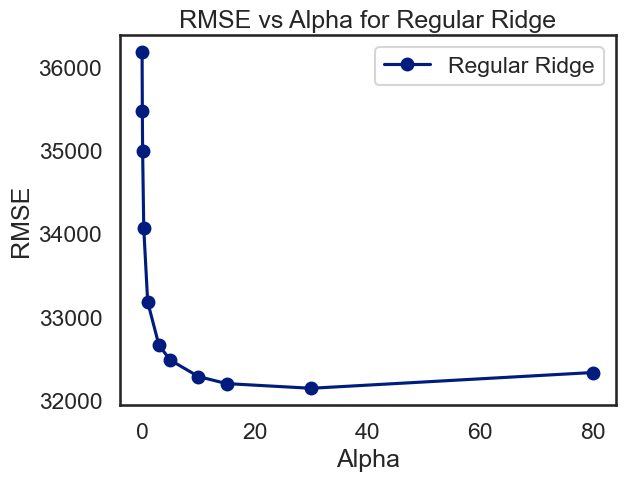

36179.32682232134
35475.33619998476
34997.656021791096
34063.5896105476
33176.56008895392
32656.45746420619
32479.04921846759
32280.600098044775
32195.726679678355
32139.503263426916
32329.25496752959


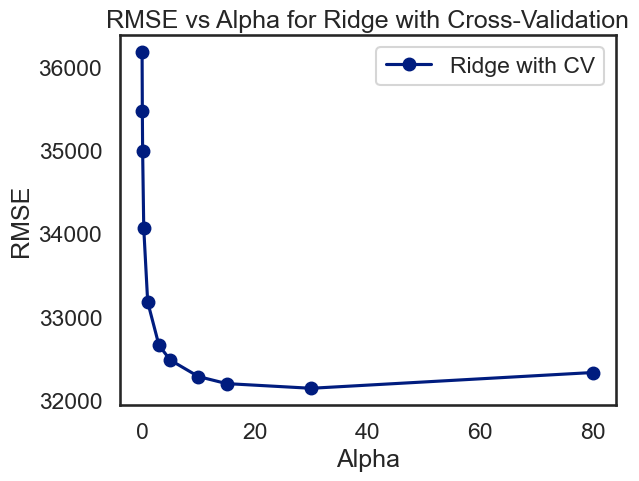

In [35]:
import matplotlib.pyplot as plt

# Define a range of alpha values
alphas = [0.005, 0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 30, 80]

# Initialize lists to store RMSE values
rmse_values_regular = []
rmse_values_cv = []

# Fit regular Ridge models to the range of alpha values and calculate RMSE
for alpha in alphas:
    # Fit Ridge model
    ridge_model = Ridge(alpha=alpha)
    ridge_model.fit(X_train_encoded, y_train)
    
    # Predict on the test set
    y_pred_regular = ridge_model.predict(X_test_encoded)
    
    # Calculate RMSE
    rmse_regular = rmse(y_test, y_pred_regular)
    rmse_values_regular.append(rmse_regular)

# Plot RMSE for regular Ridge models
plt.plot(alphas, rmse_values_regular, marker='o', label='Regular Ridge')
plt.xlabel('Alpha')
plt.ylabel('RMSE')
plt.title('RMSE vs Alpha for Regular Ridge')
plt.legend()
plt.show()

# Fit Ridge models with cross-validation and calculate RMSE
for alpha in alphas:
    # Fit Ridge model with cross-validation
    ridge_cv_model = RidgeCV(alphas=[alpha], cv=5)
    ridge_cv_model.fit(X_train_encoded, y_train)
    
    # Predict on the test set
    y_pred_cv = ridge_cv_model.predict(X_test_encoded)
    
    # Calculate RMSE
    rmse_cv = rmse(y_test, y_pred_cv)
    rmse_values_cv.append(rmse_cv)

# Plot RMSE for Ridge models with cross-validation
plt.plot(alphas, rmse_values_cv, marker='o', label='Ridge with CV')
plt.xlabel('Alpha')
plt.ylabel('RMSE')
plt.title('RMSE vs Alpha for Ridge with Cross-Validation')
plt.legend()
plt.show()

Now for the `RidgeCV` method. It's not possible to get the alpha values for the models that weren't selected, unfortunately. The resulting error values and $\alpha$ values are very similar to those obtained above.

## Question 7


Much like the `RidgeCV` function, there is also a `LassoCV` function that uses an L1 regularization function and cross-validation. L1 regularization will selectively shrink some coefficients, effectively performing feature elimination.

The `LassoCV` function does not allow the scoring function to be set. However, the custom error function (`rmse`) created above can be used to evaluate the error on the final model.

Similarly, there is also an elastic net function with cross validation, `ElasticNetCV`, which is a combination of L2 and L1 regularization.

* Fit a Lasso model using cross validation and determine the optimum value for $\alpha$ and the RMSE using the function created above. Note that the magnitude of $\alpha$ may be different from the Ridge model.
* Repeat this with the Elastic net model.
* Compare the results via table and/or plot.

Use the following alphas:  
`[1e-5, 5e-5, 0.0001, 0.0005]`

In [27]:
from sklearn.linear_model import LassoCV, ElasticNetCV

# Define alphas for Lasso and ElasticNet
alphas_lasso = [1e-5, 5e-5, 0.0001, 0.0005]
alphas_enet = [1e-5, 5e-5, 0.0001, 0.0005]

# Fit Lasso model with cross-validation
lasso_cv_model = LassoCV(alphas=alphas_lasso, cv=5)
lasso_cv_model.fit(X_train_encoded, y_train)

# Predict on the test set
y_pred_lasso = lasso_cv_model.predict(X_test_encoded)

# Calculate RMSE for Lasso model
rmse_lasso = rmse(y_test, y_pred_lasso)
print("Optimum alpha for Lasso:", lasso_cv_model.alpha_)
print("RMSE for Lasso:", rmse_lasso)

# Fit ElasticNet model with cross-validation
enet_cv_model = ElasticNetCV(alphas=alphas_enet, l1_ratio=0.5, cv=5)
enet_cv_model.fit(X_train_encoded, y_train)

# Predict on the test set
y_pred_enet = enet_cv_model.predict(X_test_encoded)

# Calculate RMSE for ElasticNet model
rmse_enet = rmse(y_test, y_pred_enet)
print("Optimum alpha for ElasticNet:", enet_cv_model.alpha_)
print("RMSE for ElasticNet:", rmse_enet)

Optimum alpha for Lasso: 0.0005
RMSE for Lasso: 36209.910732864395
Optimum alpha for ElasticNet: 0.0005
RMSE for ElasticNet: 34135.94325119285


We can determine how many of these features remain non-zero.

In [28]:
# Get the number of non-zero coefficients for Lasso model
num_nonzero_lasso = np.sum(lasso_cv_model.coef_ != 0)
print("Number of non-zero coefficients for Lasso:", num_nonzero_lasso)

# Get the number of non-zero coefficients for ElasticNet model
num_nonzero_enet = np.sum(enet_cv_model.coef_ != 0)
print("Number of non-zero coefficients for ElasticNet:", num_nonzero_enet)

Number of non-zero coefficients for Lasso: 270
Number of non-zero coefficients for ElasticNet: 271


Now try the elastic net, with the same alphas as in Lasso, and l1_ratios between 0.1 and 0.9

In [29]:
from sklearn.linear_model import ElasticNetCV

# Define alphas for ElasticNet
alphas_enet = [1e-5, 5e-5, 0.0001, 0.0005]
l1_ratios = np.linspace(0.1, 0.9, 9)

# Fit ElasticNet model with cross-validation
enet_cv_model = ElasticNetCV(alphas=alphas_enet, l1_ratio=l1_ratios, cv=5)
enet_cv_model.fit(X_train_encoded, y_train)

# Predict on the test set
y_pred_enet = enet_cv_model.predict(X_test_encoded)

# Calculate RMSE for ElasticNet model
rmse_enet = rmse(y_test, y_pred_enet)
print("Optimum alpha for ElasticNet:", enet_cv_model.alpha_)
print("Optimum l1_ratio for ElasticNet:", enet_cv_model.l1_ratio_)
print("RMSE for ElasticNet:", rmse_enet)

# Get the number of non-zero coefficients for ElasticNet model
num_nonzero_enet = np.sum(enet_cv_model.coef_ != 0)
print("Number of non-zero coefficients for ElasticNet:", num_nonzero_enet)

Optimum alpha for ElasticNet: 0.0005
Optimum l1_ratio for ElasticNet: 0.1
RMSE for ElasticNet: 33653.093083611544
Number of non-zero coefficients for ElasticNet: 271


Comparing the RMSE calculation from all models is easiest in a table.

In [36]:
import pandas as pd

# Placeholder RMSE values (replace with actual values)
rmse_lr = 35103.23026036544
rmse_ridge = 32329.25496752959
rmse_lasso = 36209.910732864395
rmse_enet = 34135.94325119285

# Define the RMSE values for each model
rmse_values = {
    'Linear': rmse_lr,
    'Ridge': rmse_ridge,
    'Lasso': rmse_lasso,
    'ElasticNet': rmse_enet
}

# Create a DataFrame
rmse_table = pd.DataFrame.from_dict(rmse_values, orient='index', columns=['RMSE'])

# Print the table
print("RMSE values for different models:")
print(rmse_table)

RMSE values for different models:
                    RMSE
Linear      35103.230260
Ridge       32329.254968
Lasso       36209.910733
ElasticNet  34135.943251


We can also make a plot of actual vs predicted housing prices as before.

In [42]:
import matplotlib.pyplot as plt

# Assuming you have already trained and tested the models and obtained predictions
y_pred_lr = model.predict(X_test)
y_pred_ridge = ridge_model.predict(X_test)
y_pred_lasso = lasso_cv_model.predict(X_test)
y_pred_enet = enet_cv_model.predict(X_test)

# Plot actual vs predicted housing prices for each model
plt.figure(figsize=(10, 6))

# Plot actual vs predicted for Linear Regression
plt.scatter(y_test, y_pred_lr, color='blue', label='Linear Regression')

# Plot actual vs predicted for Ridge Regression
plt.scatter(y_test, y_pred_ridge, color='red', label='Ridge Regression')

# Plot actual vs predicted for Lasso Regression
plt.scatter(y_test, y_pred_lasso, color='green', label='Lasso Regression')

# Plot actual vs predicted for ElasticNet Regression
plt.scatter(y_test, y_pred_enet, color='orange', label='ElasticNet Regression')

# Plot a diagonal line (perfect predictions)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='black', linestyle='--')

# Set labels and title
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Actual vs Predicted Housing Prices')
plt.legend()

# Show plot
plt.show()import matplotlib.pyplot as plt

# Assuming you have already trained and tested the models and obtained predictions
y_pred_lr = model.predict(X_test)
y_pred_ridge = ridge_model.predict(X_test)
y_pred_lasso = lasso_cv_model.predict(X_test)
y_pred_enet = enet_cv_model.predict(X_test)

# Plot actual vs predicted housing prices for each model
plt.figure(figsize=(10, 6))

# Plot actual vs predicted for Linear Regression
plt.scatter(y_test, y_pred_lr, color='blue', label='Linear Regression')

# Plot actual vs predicted for Ridge Regression
plt.scatter(y_test, y_pred_ridge, color='red', label='Ridge Regression')

# Plot actual vs predicted for Lasso Regression
plt.scatter(y_test, y_pred_lasso, color='green', label='Lasso Regression')

# Plot actual vs predicted for ElasticNet Regression
plt.scatter(y_test, y_pred_enet, color='orange', label='ElasticNet Regression')

# Plot a diagonal line (perfect predictions)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='black', linestyle='--')

# Set labels and title
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Actual vs Predicted Housing Prices')
plt.legend()

# Show plot
plt.show()

ValueError: could not convert string to float: 'TwnhsE'

## Question 8

Let's explore Stochastic gradient descent in this exercise.  
Recall that Linear models in general are sensitive to scaling.
However, SGD is *very* sensitive to scaling.  
Moreover, a high value of learning rate can cause the algorithm to diverge, whereas a too low value may take too long to converge.

* Fit a stochastic gradient descent model without a regularization penalty (the relevant parameter is `penalty`).
* Now fit stochastic gradient descent models with each of the three penalties (L2, L1, Elastic Net) using the parameter values determined by cross validation above. 
* Do not scale the data before fitting the model.  
* Compare the results to those obtained without using stochastic gradient descent.

In [45]:
from sklearn.linear_model import SGDRegressor
from sklearn.metrics import mean_squared_error

# Fit SGD model without regularization
sgd_model_no_penalty = SGDRegressor(penalty=None, random_state=42)
sgd_model_no_penalty.fit(X_train_encoded, y_train)
y_pred_sgd_no_penalty = sgd_model_no_penalty.predict(X_test_encoded)
rmse_sgd_no_penalty = mean_squared_error(y_test, y_pred_sgd_no_penalty, squared=False)

# Fit SGD models with L2, L1, and Elastic Net penalties using parameters from cross-validation
sgd_model_l2 = SGDRegressor(penalty='l2', alpha=best_alpha_ridge, random_state=42)
sgd_model_l2.fit(X_train_encoded, y_train)
y_pred_sgd_l2 = sgd_model_l2.predict(X_test_encoded)
rmse_sgd_l2 = mean_squared_error(y_test, y_pred_sgd_l2, squared=False)

sgd_model_l1 = SGDRegressor(penalty='l1', alpha=best_alpha_lasso, random_state=42)
sgd_model_l1.fit(X_train_encoded, y_train)
y_pred_sgd_l1 = sgd_model_l1.predict(X_test_encoded)
rmse_sgd_l1 = mean_squared_error(y_test, y_pred_sgd_l1, squared=False)

sgd_model_enet = SGDRegressor(penalty='elasticnet', alpha=best_alpha_enet, l1_ratio=best_l1_ratio, random_state=42)
sgd_model_enet.fit(X_train_encoded, y_train)
y_pred_sgd_enet = sgd_model_enet.predict(X_test_encoded)
rmse_sgd_enet = mean_squared_error(y_test, y_pred_sgd_enet, squared=False)

# Compare results
rmse_values_sgd = {
    'No Penalty': rmse_sgd_no_penalty,
    'L2 Penalty': rmse_sgd_l2,
    'L1 Penalty': rmse_sgd_l1,
    'Elastic Net Penalty': rmse_sgd_enet
}

print("RMSE values for SGD models:")
for penalty, rmse_value in rmse_values_sgd.items():
    print(f"{penalty}: {rmse_value}")

NameError: name 'best_alpha_ridge' is not defined

Notice how high the error values are! The algorithm is diverging. This can be due to scaling and/or learning rate being too high. Let's adjust the learning rate and see what happens.

* Pass in `eta0=1e-7` when creating the instance of `SGDClassifier`.
* Re-compute the errors for all the penalties and compare.

Now let's scale our training data and try again.

* Fit a `MinMaxScaler` to `X_train` create a variable `X_train_scaled`.
* Using the scaler, transform `X_test` and create a variable `X_test_scaled`. 
* Apply the same versions of SGD to them and compare the results. Don't pass in a eta0 this time.

In [ ]:
scaler = MinMaxScaler()


In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
